# Walmart Stpre Sales Forecasting

### Probelm Description
Participants are provided with historical sales data for 45 Walmart stores located in different regions. In the dataset, there are 45 stores with up to 99 product departments, which sums up to 421,570 entries. The goal is to find out the most suitable predicting model with the lowest weighted mean absolute error (WMAE) and predict weekly sales of each store (in test dataset).

### Exploratory Data Analysis (EDA)

In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json
import requests

#Machine learning tools
from sklearn.ensemble import RandomForestRegressor
from sklearn.utils.validation import check_X_y, check_is_fitted
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import log_loss
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix
from scipy import sparse
from scipy import stats
from scipy.stats import norm

In [30]:
# load data
# join train dataset and features, stores

train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
stores = pd.read_csv('stores.csv')
features = pd.read_csv('features.csv')

df = train.merge(features, on=['Store', 'Date'], how='inner').merge(stores, on=['Store'], how='inner')
df.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday_x,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday_y,Type,Size
0,1,1,2010-02-05,24924.50,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,A,151315
1,1,2,2010-02-05,50605.27,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,A,151315
2,1,3,2010-02-05,13740.12,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,A,151315
3,1,4,2010-02-05,39954.04,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,A,151315
4,1,5,2010-02-05,32229.38,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,A,151315


In [31]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 421570 entries, 0 to 421569
Data columns (total 17 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Store         421570 non-null  int64  
 1   Dept          421570 non-null  int64  
 2   Date          421570 non-null  object 
 3   Weekly_Sales  421570 non-null  float64
 4   IsHoliday_x   421570 non-null  bool   
 5   Temperature   421570 non-null  float64
 6   Fuel_Price    421570 non-null  float64
 7   MarkDown1     150681 non-null  float64
 8   MarkDown2     111248 non-null  float64
 9   MarkDown3     137091 non-null  float64
 10  MarkDown4     134967 non-null  float64
 11  MarkDown5     151432 non-null  float64
 12  CPI           421570 non-null  float64
 13  Unemployment  421570 non-null  float64
 14  IsHoliday_y   421570 non-null  bool   
 15  Type          421570 non-null  object 
 16  Size          421570 non-null  int64  
dtypes: bool(2), float64(10), int64(3), object(2)
mem

A    22
B    17
C     6
Name: Type, dtype: int64


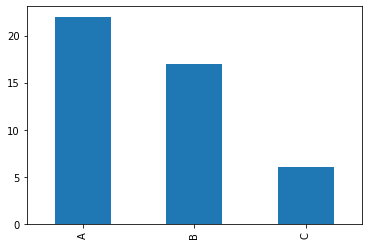

In [39]:
# find info for store types
store_type = stores['Type'].value_counts()
print(store_type)
store_type.plot(kind='bar')

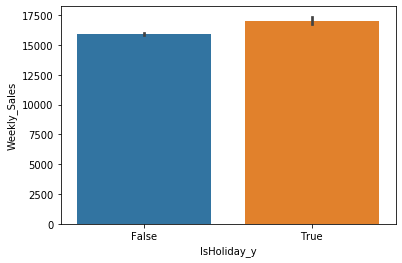

In [5]:
# check the impact of holiday
holiday = df['Weekly_Sales'].loc[df['IsHoliday_y']== True]
non_holiday = df['Weekly_Sales'].loc[df['IsHoliday_y']==False]
sns.barplot(x='IsHoliday_y', y='Weekly_Sales', data=df)

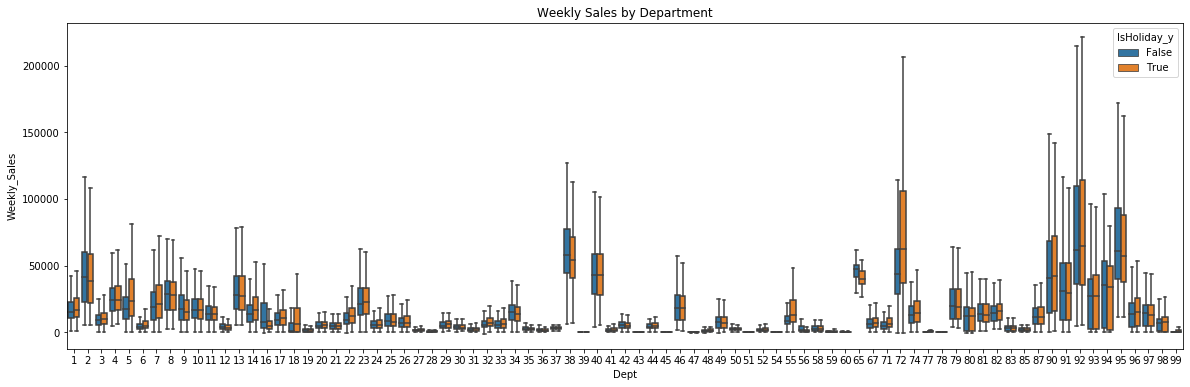

In [7]:
# check weekly sales of each department with and without holidays

plt.figure(figsize=(20, 6))
plt.title('Weekly Sales by Department')
sns.boxplot(x='Dept', y='Weekly_Sales', data=df, showfliers=False, hue="IsHoliday_y")

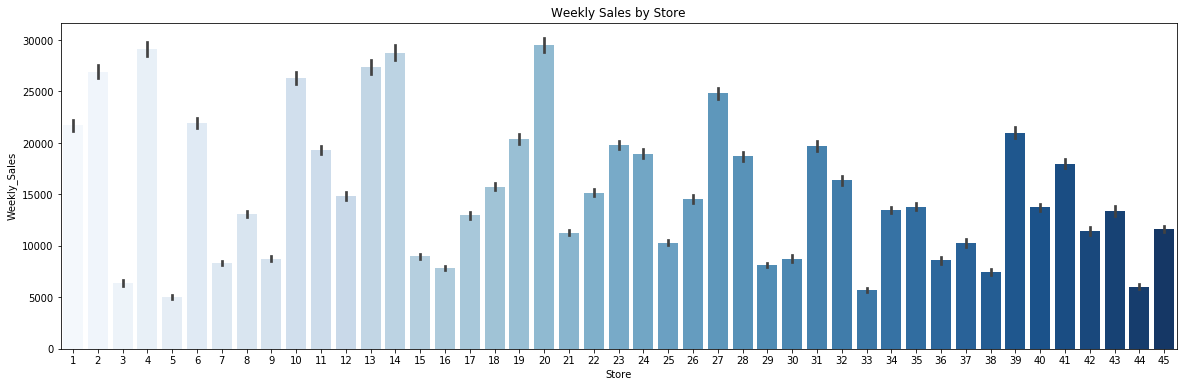

In [63]:
plt.figure(figsize=(20, 6))
plt.title('Weekly Sales by Store')
sns.barplot(x='Store', y='Weekly_Sales', data=df, palette='Blues')

### Data Processing

In [66]:
# Data pre-processing
# missing data

df = df.fillna(0)
df.isna().sum()

df = df[df['Weekly_Sales'] >= 0]

Weekly_Sales    1.000000
Size            0.244089
Dept            0.148704
MarkDown5       0.050612
MarkDown1       0.047260
MarkDown3       0.038530
MarkDown4       0.037481
MarkDown2       0.020961
IsHoliday_y     0.012856
IsHoliday_x     0.012856
Fuel_Price      0.000092
Temperature    -0.002333
CPI            -0.021153
Unemployment   -0.025831
Store          -0.085099
Name: Weekly_Sales, dtype: float64


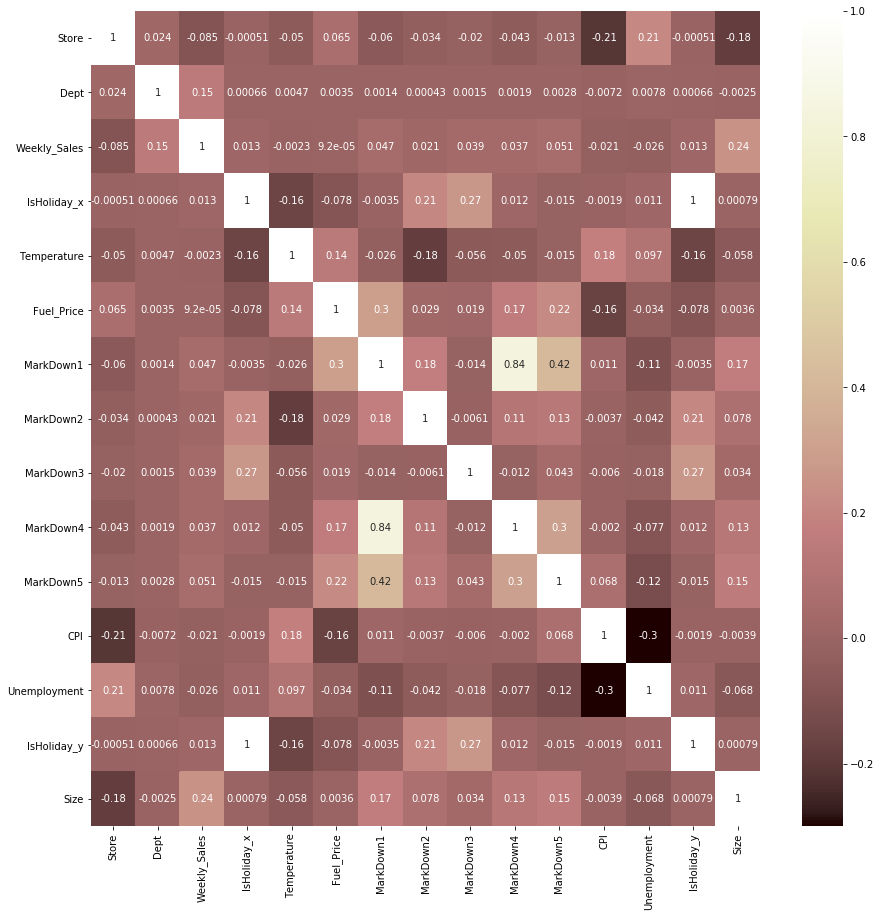

In [86]:
# find correlation between data and target variable

corr = df.corr()
plt.figure(figsize=(15,15))
sns.heatmap(corr, annot=True, cmap='pink')
print(corr['Weekly_Sales'].sort_values(ascending=False))

### Time Series Predictive Models

Auto ARIMA model (Auto Regressive Integrated Moving Average)

In [88]:
df.Date = pd.to_datetime(df.Date, format='%Y-%m-%d')
data.index = data.Date

In [51]:
# Regression models
# before applying any model, we need the data to be in the numeric format

# converting categorical variable 'Type' into numerical variables
type_mapping = {'A': 1, 'B': 2, 'C': 3}
df['Type'] = df['Type'].map(type_mapping)

# converting categorical variable 'IsHoliday' into numerical variables.
holiday_mapping = {False: 0, True: 1}
df['IsHoliday_y'] = df['IsHoliday_y'].map(holiday_mapping)

In [55]:
# Sorting the data in increasing order of Date and then splitting.
train = train.sort_values(by='Date', ascending=True)
y = train['Weekly_Sales']
X = train.drop(['Weekly_Sales'], axis=1)

# Train:Test = 70:30 splitting.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

#Train:CV = 70:30 splitting.
X_train, X_cv, y_train, y_cv = train_test_split(X_train, y_train, test_size=0.3) 

In [56]:
def wmae_train(test, pred): 
  weights = X_train['IsHoliday'].apply(lambda is_holiday:5 if   is_holiday else 1)
  error = np.sum(weights * np.abs(test - pred), axis=0) / np.sum(weights)
  return error
def wmae_cv(test, pred): # WMAE for CV
  weights = X_cv['IsHoliday'].apply(lambda is_holiday:5 if is_holiday else 1)
  error = np.sum(weights * np.abs(test - pred), axis=0) / np.sum(weights)
  return error
def wmae_test(test, pred): # WMAE for test
  weights = X_test['IsHoliday'].apply(lambda is_holiday:5 if is_holiday else 1)
  error = np.sum(weights * np.abs(test - pred), axis=0) / np.sum(weights)
  return error

In [57]:
# Apply random forest regression
# Define the list of errors and list of hyper parameters.
error_cv_rf = []
error_train_rf = []
max_depth = [1,5,10,15,20,25,30,35]
n_estimators = [10,20,30,40,50,60,70,80]
rf_hyperparams = []
"""Calculating train and CV errors for maximum depth and number of estimators parameters."""
for i in max_depth: 
    for j in n_estimators: 
        rf = RandomForestRegressor(max_depth=i, n_estimators=j) 
        rf.fit(X_train, y_train) 
        y_pred_cv_rf = rf.predict(X_cv) 
        y_pred_train_rf = rf.predict(X_train) 
        error_cv_rf.append(wmae_cv(y_cv, y_pred_cv_rf)) 
        error_train_rf.append(wmae_train(y_train, y_pred_train_rf)) 
        rf_hyperparams.append({'Maximum Depth':i, 'No. of Estimators':j}) 

ValueError: could not convert string to float: '2010-07-23'

In [59]:
# Predict the test data and calculate WMAE score

model_rf = RandomForestRegressor(max_depth= 35, n_estimators=80).fit(X_train, y_train) # Fit the model with best hyper parameter values.
y_pred = model_rf.predict(X_test) # Predict the test data.
print('Weighted Mean Absolute Error (WMAE) for Random Forest Regression:', wmae_test(y_test, y_pred)) # Get WMAE score.

ValueError: could not convert string to float: '2010-07-23'